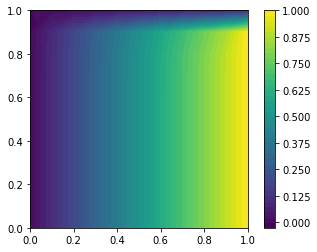

error_L2  = 0.45216065775430214


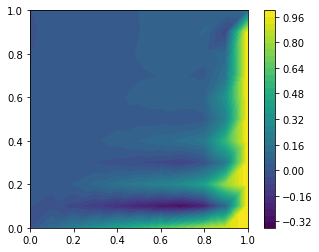

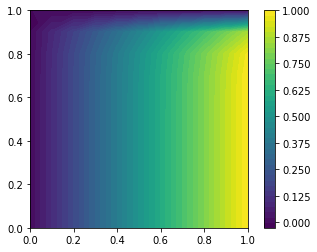

error_L2  = 0.3546516549763857


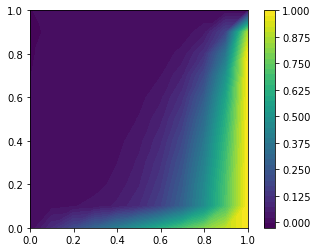

0.3136472696962717


In [7]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
for i in range(2):
    case = '_usual'
    N = 10
    mu = 0.01
    b = Constant([0,1])
    r = Constant(0)
    f = Constant(0.0)
    frm = 1
    pe = frm*1/(N * 2 * mu)
    sigma = 1/(frm*2 * N)*(1/np.tanh(pe) -1/pe)
    if i == 1:
        case = "_supg"
        mu = mu + sigma
    #print(sigma)
    # Create mesh and define function space
    mesh = UnitSquareMesh(N, N)

    V = FunctionSpace(mesh, "P", 1)

    # Define boundary condition
    import sympy as sym
    x, y = sym.symbols('x[0], x[1]')  
    u_D = (x) * ((1 - sym.exp((y - 1)/mu)) / (1 - sym.exp(-2/mu)))
    u_D = sym.simplify(u_D)
    u_D = Expression(sym.printing.ccode(u_D), degree=5)

    x = SpatialCoordinate(mesh)
    u_D = project(u_D, FunctionSpace(mesh, "P", 4))
    #u_D = Expression('1 + 2*x[0]*x[0] + 3*x[1]*x[1]', degree=2)
    mu = Constant(mu)
    def boundary(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, u_D, boundary)
    # Define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)

    a = -mu * dot(grad(u), grad(v))*dx + r*u*v*dx + dot(b,grad(u))*v*dx
    L = f*v*dx
    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    c2 = plot(u_D)
    plt.colorbar(c2)
    plt.show()
    # Plot solution and mesh
    c = plot(u)
    plt.colorbar(c)
    #plot(mesh)
    # Save solution to file in VTK format
    vtkfile = File('adr/solution_comp'+case+'.pvd')
    vtkfile << u
    vtkfile = File('adr/solution_ex'+case+'.pvd')
    vtkfile << u_D
    
    # Compute error in L2 norm
    error_L2 = errornorm(u_D, u, 'L2', degree_rise = 4)
    u1 = Function(V)
    print('error_L2  =', error_L2)
    if case == '_usual':
        u1 = u
    # Hold plot
    plt.show()
    if case == "_supg":
        print(errornorm(u1, u, 'L2', degree_rise = 4))
